<a href="https://colab.research.google.com/github/Kyrylo-Bakumenko/Blind_Rubiks_Cube_Solver/blob/main/Height_Calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install filterpy
!pip install sympy

     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110451 sha256=8d12b6b109de42a883bf58dca04da002361161b35e3f91b2426756f5d426d3d2
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


In [ ]:
import pandas as pd
import numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad
# curve-fit() function imported from scipy 
from scipy.optimize import curve_fit 
  
from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = (8, 10)
plt.rcParams['axes.facecolor'] = '#fff'
plt.rcParams['axes.edgecolor'] = '#cfcfcf'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

In [ ]:
from filterpy.kalman import FixedLagSmoother, KalmanFilter
import numpy.random as random

def kf_smooth(zs):
  fls = FixedLagSmoother(dim_x=2, dim_z=1, N=10)

  fls.x = np.array([0., .5])
  fls.F = np.array([[1.,1.],
                    [0.,1.]])

  fls.H = np.array([[1.,0.]])
  fls.P *= 200
  fls.R *= 5.
  fls.Q *= 0.001

  kf = KalmanFilter(dim_x=2, dim_z=1)
  kf.x = np.array([0., .5])
  kf.F = np.array([[1.,1.],
                  [0.,1.]])
  kf.H = np.array([[1.,0.]])
  kf.P *= 200
  kf.R *= 5.
  kf.Q *= 0.001

  N = 4 # size of lag

  # nom =  df['Time'][1:]
  # zs = df.Altitude[1:]
  # zs = df.Velocity[1:]

  for z in zs:
      fls.smooth(z)
      
  kf_x, _, _, _ = kf.batch_filter(zs)
  x_smooth = np.array(fls.xSmooth)[:, 0]

  return x_smooth, kf_x[:, 0]


In [ ]:
MASS = 0.420

In [ ]:
df = pd.read_excel('Rocket Velocity Targets.xls', sheet_name='Sheet1')

In [ ]:
df.head()

,Time,Altitude
0,0.90,0
1,0.95,1
2,1.00,2
3,1.05,5
4,1.10,52


In [ ]:
kf_alt_smooth, kf_alt_filter = kf_smooth(df['Altitude'])

df.loc[:, 'Altitude'] = kf_alt_smooth
df.head()

,Time,Altitude
0,0.90,0.006173
1,0.95,0.958636
2,1.00,2.058637
3,1.05,4.791102
4,1.10,34.356756


In [ ]:
df['Velocity'] = (df['Altitude'] - df['Altitude'].shift(1))/(df['Time'] - df['Time'].shift(1))
kf_vel_smooth, kf_vel_filter = kf_smooth(df.loc[1:,'Velocity'])
df.loc[1:, 'Velocity'] = kf_vel_smooth
df.head()

,Time,Altitude,Velocity
0,0.90,0.006173,NaN
1,0.95,0.958636,18.820266
2,1.00,2.058637,22.673795
3,1.05,4.791102,48.082647
4,1.10,34.356756,424.318827


In [ ]:
df.set_index('Time')[['Velocity', 'Altitude']].plot(secondary_y='Altitude');

NameError: ignored

In [ ]:
# GOAL #
# Find Gap Size as a function of Altitiude and Time #

In [ ]:
def alt(time):
  print(time)
  return df[df.Time == time]['Altitude'].values[0]

,Time,Altitude,Velocity,Acceleration
0,0.90,0.006173,NaN,NaN
1,0.95,0.958636,18.820266,NaN
2,1.00,2.058637,22.673795,77.070580
3,1.05,4.791102,48.082647,508.177036
4,1.10,34.356756,424.318827,7524.723611
...,...,...,...,...
205,11.15,688.486238,-27.237120,25.218519
206,11.20,687.345732,-26.363268,17.477036
207,11.25,686.229621,-25.369855,19.868259
208,11.30,684.555628,-24.395298,19.491137


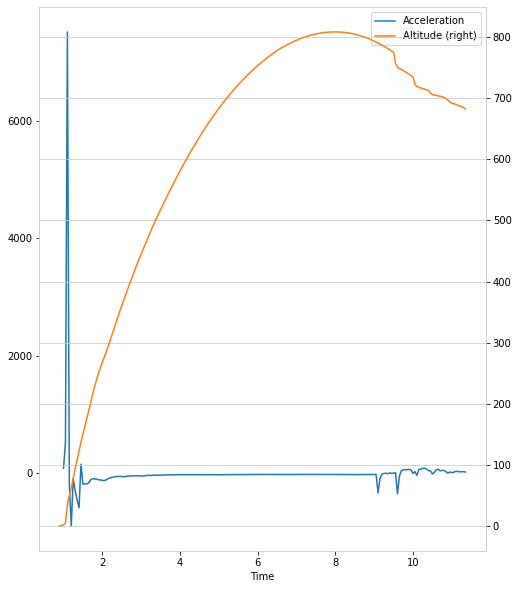

In [ ]:
df['Acceleration'] = (df['Velocity'] - df['Velocity'].shift(1))/(df['Time'] - df['Time'].shift(1))
df.set_index('Time')[['Acceleration', 'Altitude']].plot(secondary_y='Altitude');
df

,Time,Altitude,Velocity,Acceleration,Force
0,0.90,0.006173,NaN,NaN,NaN
1,0.95,0.958636,18.820266,NaN,NaN
2,1.00,2.058637,22.673795,77.070580,NaN
3,1.05,4.791102,48.082647,508.177036,1026.443943
4,1.10,34.356756,424.318827,7524.723611,16706.063273
...,...,...,...,...,...
205,11.15,688.486238,-27.237120,25.218519,2.489828
206,11.20,687.345732,-26.363268,17.477036,-18.432103
207,11.25,686.229621,-25.369855,19.868259,5.693389
208,11.30,684.555628,-24.395298,19.491137,-0.897911


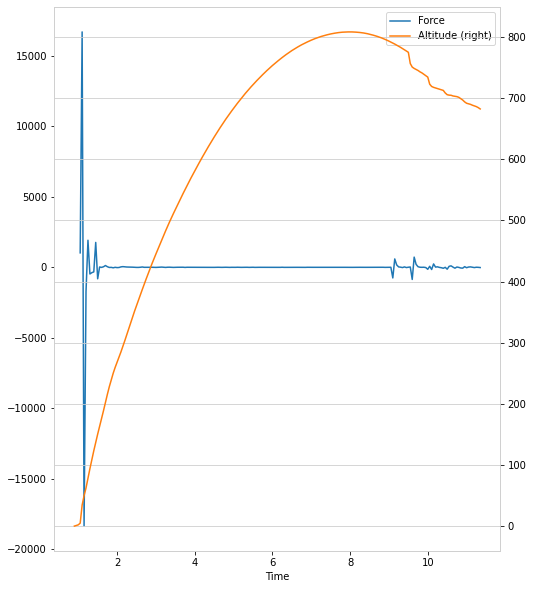

In [ ]:
df['Force'] = (df['Acceleration'] - df['Acceleration'].shift(1))/MASS
df.set_index('Time')[['Force', 'Altitude']].plot(secondary_y='Altitude');
df

In [ ]:
df['Drag Force'] = df['Force'] - MASS*9.8
print(df)
df[df.Time == 4]['Drag Force'].values[0]

      Time    Altitude    Velocity  Acceleration         Force    Drag Force
0     0.90    0.006173         NaN           NaN           NaN           NaN
1     0.95    0.958636   18.820266           NaN           NaN           NaN
2     1.00    2.058637   22.673795     77.070580           NaN           NaN
3     1.05    4.791102   48.082647    508.177036   1026.443943   1022.327943
4     1.10   34.356756  424.318827   7524.723611  16706.063273  16701.947273
..     ...         ...         ...           ...           ...           ...
205  11.15  688.486238  -27.237120     25.218519      2.489828     -1.626172
206  11.20  687.345732  -26.363268     17.477036    -18.432103    -22.548103
207  11.25  686.229621  -25.369855     19.868259      5.693389      1.577389
208  11.30  684.555628  -24.395298     19.491137     -0.897911     -5.013911
209  11.35  682.395150  -23.761153     12.682905    -16.210075    -20.326075

[210 rows x 6 columns]


-4.5798846921367415

Sine funcion coefficients:
[ -15.81865425  251.23054231 -181.74218914]
Covariance of coefficients:
[[ 1.58384704e-02 -1.94021261e-01  4.48677466e-01]
 [-1.94021261e-01  2.49316263e+00 -6.20926238e+00]
 [ 4.48677466e-01 -6.20926238e+00  1.81466069e+01]]


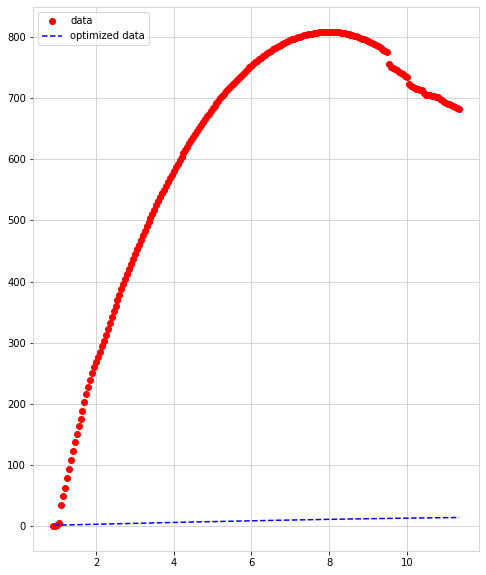

In [ ]:
# numpy.linspace with the given arguments 
# produce an array of 40 numbers between 0 
# and 10, both inclusive 
x = df.Time
y = df.Altitude
  
# y is another array which stores 3.45 times 
# the sine of (values in x) * 1.334.  
# The random.normal() draws random sample  
# from normal (Gaussian) distribution to make 
# them scatter across the base line 
# y = 3.45 * np.sin(1.334 * x) + np.random.normal(size = 40) 
  
# Test function with coefficients as parameters 
def test(x, a, b, c=0): 
    return a*(x**2) + b*(x) + c 
  
# curve_fit() function takes the test-function 
# x-data and y-data as argument and returns  
# the coefficients a and b in param and 
# the estimated covariance of param in param_cov 
param, param_cov = curve_fit(test, x, y) 
  
  
print("Sine funcion coefficients:") 
print(param) 
print("Covariance of coefficients:") 
print(param_cov) 
  
# ans stores the new y-data according to  
# the coefficients given by curve-fit() function 
ans = (param[0]*(np.sin(param[1]*x))) 
  
'''Below 4 lines can be un-commented for plotting results  
using matplotlib as shown in the first example. '''
  
plt.plot(x, y, 'o', color ='red', label ="data") 
plt.plot(x, ans, '--', color ='blue', label ="optimized data") 
plt.legend() 
plt.show() 

582.6030997120258
685.7295317322287
638.5317172254114
803.4298564654733 808.4080475946821


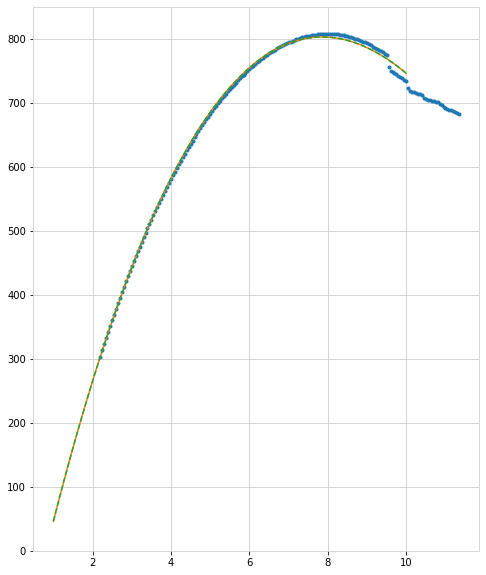

In [ ]:
import warnings
# x = np.array([0.0, 1.0, 2.0, 3.0,  4.0,  5.0])
x = df['Time'][df.Altitude > 300]
# y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0])
y = df['Altitude'][df.Altitude > 300]
z = np.polyfit(x, y, 3)

# may vary
# It is convenient to use poly1d objects for dealing with polynomials:

p = np.poly1d(z)

# High-order polynomials may oscillate wildly:

with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p2 = np.poly1d(np.polyfit(x, y, 2))

with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p3 = np.poly1d(np.polyfit(x, y, 3))

print(p3(4))
# may vary
print(p3(5))
# may vary
print(p3(4.5))
# may vary
# Illustration:


import matplotlib.pyplot as plt
xp = np.linspace(1, 10, 100)
print(p3(xp).max(), df.Altitude.max())
_ = plt.plot(x, y, '.', xp, p(xp), '-', xp, p3(xp), '--')
plt.ylim(0, 850)
plt.show()

In [ ]:
time_at_peak = df[df.Altitude == df.Altitude.max()]['Time'].values[0]
deploy_alt = p2(df[df.Altitude > 600][df.Time < time_at_peak]['Time'].values[0])
deploy_time = df[df.Altitude > 600][df.Time < time_at_peak]['Time'].values[0]
print('Time at deployment', deploy_time)
print(p2)
coef_for_curve = p2.coef[0]
print(p3)
coef_for_curve = p3.coef[0]

Time at deployment 4.2
       2
-14.6 x + 233.2 x - 122.6
        3         2
0.4191 x - 23.12 x + 285.6 x - 216.9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
drag_increase_prop = 1.914/1.841
# drag_increase_prop = 1
# drag_increase_prop = 10
def estimate_function(x):
  return coef_for_curve*drag_increase_prop*(x**2) +  216.8*x - 60.25

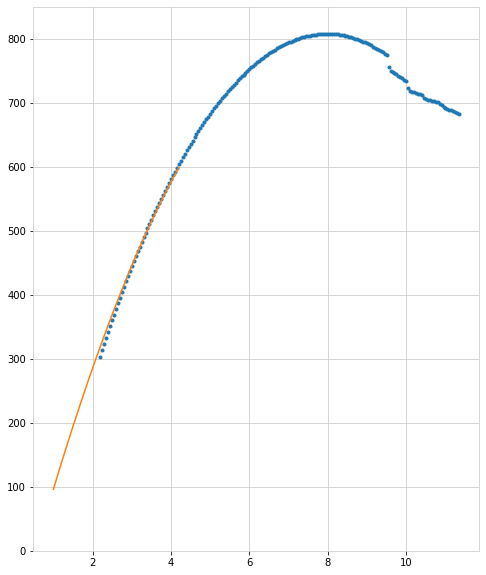

2456.5606531768976


In [ ]:
x1 = np.linspace(1, deploy_time)
x2 = np.linspace(deploy_time, df.Time.max())
_ = plt.plot(x, y, '.', x1, p2(x1), '-', x2, estimate_function(x2), '--')
plt.ylim(0, 850)
plt.show()
print(estimate_function(x2).max())

In [ ]:
df['Altitude_Deployed'] = df['Altitude']
for i in range(len(df['Altitude'])):
  if df['Time'][i] < 4.2:
    df['Altitude_Deployed'][i] = df['Altitude'][i]
  else:
    df['Altitude_Deployed'][i] = -29.2*drag_increase_prop*(df['Time'][i]-4.2)**2+df[df.Time == 4.2]['Velocity'].values[0]*(df['Time'][i]-4.2) + 609

In [ ]:
kf_vel_smooth, kf_vel_filter = kf_smooth(df.loc[1:,'Altitude_Deployed'])
df.loc[1:, 'Altitude_Deployed'] = kf_vel_smooth

In [ ]:
df['Velocity_Deployed'] = (df['Altitude_Deployed'] - df['Altitude_Deployed'].shift(1))/(df['Time'] - df['Time'].shift(1))

kf_vel_smooth, kf_vel_filter = kf_smooth(df.loc[1:,'Velocity_Deployed'])
df.loc[1:, 'Velocity_Deployed'] = kf_vel_smooth

In [ ]:
df['Acceleration_Deployed'] = (df['Velocity_Deployed'] - df['Velocity_Deployed'].shift(1))/(df['Time'] - df['Time'].shift(1))

In [ ]:
def Fd_q(v, p=1, m=0.446, A=0.00442, rho=1.241, Cd=1.3):
  v = v * 0.3048
  return -p*(Cd*A*rho*  (v**2)  )/(2*m)


def Fd_l(v, p=1, m=0.446, A=0.00442, rho=1.241, Cd=75):
  v = v * 0.3048
  return -p*(Cd*A*rho*v)/(2*m)


def a(v, m=0.446, p=1):
  return Fd_l(v=v, m=m, p=p)/m - 9.81


def max_height(v, s, m=0.446, p=1, del_t=0.1, A=0):
  v_dep = v
  s_dep = s
  while v > 0:
    s = s + v*del_t
    v = v + del_t*a(v=v, m=m)
                      # if abs(A) > abs(a(v=v, m=m)):
                      #   v = v + del_t*A
                      # else:
                      #   v = v + del_t*a(v=v, m=m)
  while v_dep > 0:
    s_dep = s_dep + v_dep*del_t
    v_dep = v_dep + del_t*a(v_dep, m=m, p=p)
  return s, s_dep

In [ ]:
def poly(x, df, deployed=False):
  # a = -abs(df[df.Time == x]['Acceleration'].values[0])
  # b = abs(df[df.Time == x]['Velocity'].values[0])
  # c = abs(df[df.Time == x]['Altitude'].values[0])

  

  a = -abs(df[df.Time == x]['Acceleration_Deployed'].values[0])
  b = abs(df[df.Time == x]['Velocity_Deployed'].values[0])
  c = abs(df[df.Time == x]['Altitude_Deployed'].values[0])

  if abs(a) < 0.1:
    a = -1

  t_max = -b/a
  current = ((0.5*a*t_max**2) + b*t_max + c)

  t_max = -b/(a*drag_increase_prop)
  new = ((0.5*a*drag_increase_prop*t_max**2) + b*t_max + c)

  # if abs(750-new) < abs(750-current) and c > 600 and not deployed:
  # return (x, current, new)
  return x, max_height(v=b, s=c, p=1.242)[0], max_height(v=b, s=c, p=1.242, A=a)[1]


In [ ]:
estimates = []
for i in np.arange(2., 8.0, 0.05):
  i = round(i, 3)
  estimates.append(poly(i, df))

s = pd.DataFrame(estimates, columns=['Time', 'Not-Deployed', 'Deployed'])

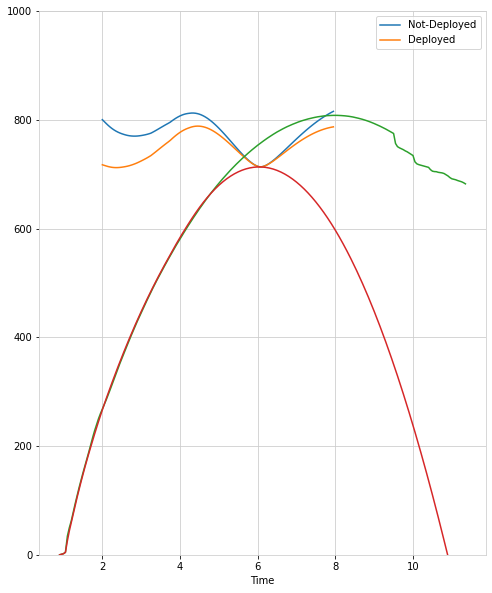

In [ ]:
s.set_index('Time').plot();
plt.ylim(0, 1000)
df.set_index('Time')['Altitude'].plot();
df.set_index('Time')['Altitude_Deployed'].plot();
# df.set_index('Time')['Velocity_Deployed'].plot()

In [ ]:
a = (df[df.Time == 3.0]['Velocity'].values[0] - df[df.Time == 9.0]['Velocity'].values[0])/6
a

31.04952674876043

In [ ]:
df[df.Time == 3.0]['Velocity']

42    157.405396
Name: Velocity, dtype: float64

In [ ]:
v = df[df.Time == 4.2]['Velocity'].values[0]*0.3048
v = 0.3048*v
print(v)

10.393885322750334


In [ ]:
df['Acceleration'] = (df['Velocity'] - df['Velocity'].shift(1))/(df['Time'] - df['Time'].shift(1))

In [ ]:
df[df.Time == 4.2]['Acceleration']

66   -29.857336
Name: Acceleration, dtype: float64

In [ ]:
# from __future__ import division
# from sympy import *
# y = Function('y')
# dsolve(Eq(y(t).diff(t, t) - y(t), exp(t)), y(t))

In [ ]:
import math
### ft/s to m/s convert ration: 1 : 0.3048
m = 0.446 # Kg
v = df[df.Time == 4.2]['Velocity'].values[0]*0.3048 # m/s
Fd = abs((df[df.Time == 4.2]['Acceleration'].values[0]+9.81)*m)  # N
diameter = 75 # mm
### mm**2 to m**2 ration: 1 : 1e-6
A = math.pi*((diameter/2)**2)/1_000_000 # m**2
r = 1.24 # Kg/m**3

Cd = 2*m*Fd/(A*r*(v**2))
print("A:", A,"v:", v, Cd)

A: 0.004417864669110647 v: 34.10067363107065 1.2519770697218946


In [ ]:
Fd

8.941111897652528

In [ ]:
df[df.Time == 4.2]

,Time,Altitude,Velocity,Acceleration,Force,Drag Force,Altitude_Deployed,Velocity_Deployed,Acceleration_Deployed
66,4.2,604.131159,111.87885,-29.857336,3.346338,-0.769662,606.929457,111.126997,-39.89559


In [ ]:
Fd = (Cd*A*r*v**2)/(2*m)
Fd

8.941111897652528

In [ ]:
0.3048 * 111.88

34.101024

In [ ]:
a(111.88)

-33.860296648448724

In [ ]:
max_height(111.88, 604.13, p=1.242)

(817.905126219878, 789.8778591378938)

In [ ]:
df.head(50)

,Time,Altitude,Velocity,Acceleration,Force,Drag Force,Altitude_Deployed,Velocity_Deployed,Acceleration_Deployed
0,0.90,0.006173,NaN,NaN,NaN,NaN,0.006173,NaN,NaN
1,0.95,0.958636,18.820266,NaN,NaN,NaN,0.952974,18.708421,NaN
2,1.00,2.058637,22.673795,77.070580,NaN,NaN,2.042448,22.486819,75.567966
3,1.05,4.791102,48.082647,508.177036,1026.443943,1022.327943,4.477815,43.084442,411.952459
4,1.10,34.356756,424.318827,7524.723611,16706.063273,16701.947273,25.681430,305.916796,5256.647074
5,1.15,49.796251,414.913423,-188.108078,-18363.884974,-18368.000974,43.967489,380.328983,1488.243739
6,1.20,62.386606,369.464680,-908.974869,-1716.349502,-1720.465502,59.427344,378.840452,-29.770608
7,1.25,78.268977,364.368800,-101.917596,1921.564936,1917.448936,75.015865,368.593912,-204.930796
8,1.30,93.819919,349.339953,-300.576939,-472.998436,-477.114436,90.461673,350.810223,-355.673791
9,1.35,108.836916,326.363247,-459.534131,-378.469504,-382.585504,105.550431,326.366702,-488.870426
